In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [4]:
from PIL import Image
import glob
import os
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

In [146]:
def load_images_from_folder(folder):
    image_list = []
    for filename in os.listdir(folder):
        #img = cv2.imread(os.path.join(folder,filename))
        img = image.load_img(os.path.join(folder,filename), target_size = (224, 224))
        if img is not None:
            x = image.img_to_array(img)
            x = x / 255
            #x = np.expand_dims(x, axis = 0) 
            image_list.append(x)
    return image_list


# training data
corona_list_train = load_images_from_folder('./corona3class/train/corona')
normal_list_train = load_images_from_folder('./corona3class/train/normal')
phen_list_train = load_images_from_folder('./corona3class/train/phenomonia')

# Testing data
corona_list_test = load_images_from_folder('./corona3class/test/corona')
normal_list_test = load_images_from_folder('./corona3class/test/normal')
# corona_list_test = load_images_from_folder('./corona_testing_data/corona')
# normal_list_test = load_images_from_folder('./corona_testing_data/normal')
phen_list_test = load_images_from_folder('./corona3class/test/phenomonia')

In [147]:
# converting images into array of list
corona_test = np.array(corona_list_test)
normal_test = np.array(normal_list_test)
phen_test = np.array(phen_list_test)

corona_train = np.array(corona_list_train)
normal_train = np.array(normal_list_train)
phen_train = np.array(phen_list_train)

print(len(corona_test))
print(len(normal_test))
print(len(phen_test))

print(corona_test[0].shape)
print(corona_test.shape)
print(phen_test.shape)

print()
print(normal_train.shape)
print(corona_train.shape)
print(phen_train.shape)

72
138
162
(224, 224, 3)
(72, 224, 224, 3)
(162, 224, 224, 3)

(148, 224, 224, 3)
(148, 224, 224, 3)
(148, 224, 224, 3)


In [7]:
IMAGE_SHAPE = 224
batch_size = 32

In [157]:
image_gen = ImageDataGenerator(rescale = 1./255,
                              shear_range = 0.2, 
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                              fill_mode = 'nearest'
                              )

test_gen = ImageDataGenerator(rescale = 1./255,
                              )


In [158]:
train_dir = './corona3class/train'
test_dir = './corona3class/test'

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMAGE_SHAPE,IMAGE_SHAPE),
                                                class_mode='sparse'
                                              )

test_data_gen = test_gen.flow_from_directory(directory = test_dir,
                                           target_size = (IMAGE_SHAPE,IMAGE_SHAPE),
                                           batch_size = batch_size,
                                           class_mode='sparse'
                                           )

Found 444 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


# CALL BACKS

In [159]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("corona_model_callback10.h5",
                              monitor = "val_loss",    # here we specify which value we want to monitor. 
                              mode = "min",
                              save_best_only = True,
                              verbose = 1
                            )

earlystop = EarlyStopping(monitor = 'val_loss',   # value being monitored for improvement
                          min_delta = 0,          # it is the absolute value and  it is the min change required before we stop.
                          patience = 10,         # num of epochs we wait before we stop training 
                          verbose = 1,
                          restore_best_weights = True
                         )

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, verbose = 1, min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

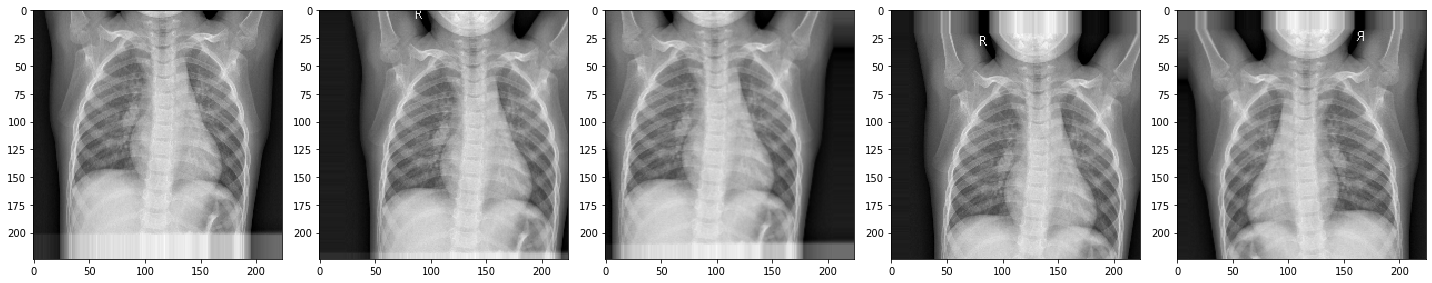

In [160]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# MY CNN MODEL

In [164]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SHAPE,IMAGE_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))   # my edit
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))                        # my edit
model.add(Dense(1024, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(3))

In [162]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 25
history = model.fit_generator(train_data_gen,
                              steps_per_epoch= int(np.ceil(train_data_gen.n / float(batch_size))),
                              epochs=EPOCHS,
                              callbacks = callbacks,
                              validation_data=test_data_gen,
                              validation_steps= int(np.ceil(test_data_gen.n / float(batch_size)))
                             )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 14 steps, validate for 12 steps
Epoch 1/25
13/14 [==========================>...] - ETA: 2s - loss: 1.0892 - accuracy: 0.4199
Epoch 00001: val_loss improved from inf to 0.96067, saving model to corona_model_callback10.h5
14/14 [==============================] - 49s 4s/step - loss: 1.0775 - accuracy: 0.4302 - val_loss: 0.9607 - val_accuracy: 0.5753
Epoch 2/25
13/14 [==========================>...] - ETA: 1s - loss: 0.6679 - accuracy: 0.7209
Epoch 00002: val_loss improved from 0.96067 to 0.51788, saving model to corona_model_callback10.h5
14/14 [==============================] - 37s 3s/step - loss: 0.6409 - accuracy: 0.7365 - val_loss: 0.5179 - val_accuracy: 0.7903
Epoch 3/25
13/14 [==========================>...] - ETA: 1s - loss: 0.3942 - accuracy: 0.8617
Epoch 00003: val_loss did not improve from 0.51788
14/14 [==============================] - 36s 3s/step - loss: 0.3810 - accuracy: 0.8649 - val_loss: 0.6813 - val_accuracy: 0

# Plotting Graph againt training AND testing

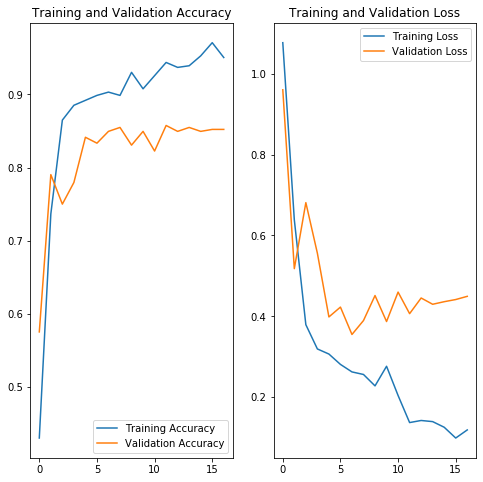

In [167]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(17)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Doing Predictions

In [28]:
# for testing corona
# result = model.predict(corona_test[8][np.newaxis, ...])
# result.shape


result = model.predict_classes(corona_test[0][np.newaxis, ...])
result

# model.predict_classes(corona_test[12][np.newaxis, ...])

# for testing corona
# predicted_class = np.argmax(result[0], axis=-1)
# predicted_class

array([0], dtype=int64)

In [29]:
# for testing normal
# result = model.predict(normal_test[15][np.newaxis, ...])
# result.shape

model.predict_classes(normal_test[19][np.newaxis, ...])

# # for testing normal
# predicted_class = np.argmax(result[0], axis=-1)
# predicted_class

array([1], dtype=int64)

In [51]:
model.predict_classes(phen_test[20][np.newaxis, ...])

array([2], dtype=int64)

In [ ]:
print(corona_test.shape)
print(corona_test[0].shape)
single_img_test = np.expand_dims(corona_test[0], axis = 0)
print(single_img_test.shape)

In [ ]:
print(normal_test.shape)
print(normal_test[0].shape)
single_img_test = np.expand_dims(normal_test[0], axis = 0)
print(single_img_test.shape)

In [53]:
train_data_gen.class_indices 

{'corona': 0, 'normal': 1, 'phenomonia': 2}

In [52]:
model.save('three_class_covid_model2.h5')

In [139]:
from tensorflow.keras.models import load_model

classifier = load_model('corona_model_callback7.h5')

In [144]:
def count_wrong_preds(sample, actual_pred):
    j = 0
    for i in range(len(sample)):
        pred = classifier.predict_classes(sample[i][np.newaxis, ...])
        if pred != actual_pred:
            j += 1
    return j

In [148]:
corona = count_wrong_preds(corona_test, train_data_gen.class_indices['corona'])
normal = count_wrong_preds(normal_test, train_data_gen.class_indices['normal'])
phen = count_wrong_preds(phen_test, train_data_gen.class_indices['phenomonia'])
print("Corona test wrong predictions:    {}  out of {}".format(corona, len(corona_test)))
print("Normal test wrong predictions:    {}  out of {}".format(normal, len(normal_test)))
print("pneumonia test wrong predictions: {}  out of {}".format(phen, len(phen_test)))
print("Total wrong predictions: {}".format(corona+normal+phen))

Corona test wrong predictions:    6  out of 72
Normal test wrong predictions:    20  out of 138
pneumonia test wrong predictions: 18  out of 162
Total wrong predictions: 44
